- **Date:** 2019-5-27
- **Author:** Zhanyuan Zhang
- **Purpose:** 
    1. Use saliency map to visualize the locations of patches.
    2. Confirm that each unit in the top-most feature map is a 2048-dimension vector.
    3. Generate patches at the same locations and make prediction by these patches.
    4. Visualize the saliency map of a patch.
    5. Compare saliency maps of patches generated by feeding in the entire image and directly feeding in patches.
- **Overall:** This notebook developed tools for using saliency map to visualize corresponding receptive field of each spatial position in the output. To make sure that only some specific spatial positions have activation, here I define a *MaskLayer* to mask out other spatial positions that we do not need. Thereby, we can control the source of salient signals.
- **Conclusion:** The saliency maps of the first patch (at the top-left corner) generated by two different approaches are different. This may indicate that the two ways of using Bagnet are not equivalent.

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/dl-security/') #Change the path to the directory that contains all code and data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install https://github.com/bethgelab/foolbox/archive/master.zip

     | 5.7MB 1.6MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-u_lkjn8r/wheels/3d/cb/2b/54e486add16cbc5a86392b539df012f5a775faa609321caaf4
Successfully built foolbox


In [0]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from bagnets.utils import pad_image, convert2channel_last, imagenet_preprocess, extract_patches, bagnet_predict, compare_heatmap
from bagnets.utils import bagnet33_debug, plot_saliency, compute_saliency_map
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import time
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla T4


## 1. BagNet-33 with receptive field mode
Here I use both pre-trained model and initial model (model without training) to visualize the patches.

#### Define a modified BagNet-33 that is capable to visualize receptive fields:

In [0]:
from bagnets.pytorch import Bottleneck
import torch.nn as nn
import math
from torch.utils import model_zoo

model_urls = {
            'bagnet9': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet8-34f4ccd2.pth.tar',
            'bagnet17': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar',
            'bagnet33': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar',
                            }

class BottleneckRF(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, kernel_size=1):
        super(BottleneckRF, self).__init__()
        # print('Creating bottleneck with kernel size {} and stride {} with padding {}'.format(kernel_size, stride, (kernel_size - 1) // 2))
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=stride,
                               padding=0, bias=False) # changed padding from (kernel_size - 1) // 2
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x, **kwargs):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            #print('Bottleneck: shape before downsampling {}'.format(x.shape))
            residual = self.downsample(x)
        
        if residual.size(-1) != out.size(-1):
            #print('Bottleneck: shape after downsampling {}'.format(residual.shape))
            #print('Bottleneck: shape of out {}'.format(out.shape))
            diff = residual.size(-1) - out.size(-1)
            residual = residual[:,:,:-diff,:-diff]
        
        out += residual
        out = self.relu(out)

        return out

class MaskLayer(nn.Module):
    
    def __init__(self, shape, coordinate, device):
        super(MaskLayer, self).__init__()
        X, Y = coordinate
        self.mask = torch.zeros(shape).to(device)
        for x in X:
            for y in Y:
                self.mask[:, :, x, y] = 1
        
    def forward(self, x):
        return x*self.mask


class BagNetRF(nn.Module):

    def __init__(self, block, layers, mask=None, strides=[1, 2, 2, 2], kernel3=[0, 0, 0, 0], num_classes=1000, avg_pool=True):
        self.inplanes = 64
        super(BagNetRF, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0,
                               bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.001)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], kernel3=kernel3[0], prefix='layer1')
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], kernel3=kernel3[1], prefix='layer2')
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], kernel3=kernel3[2], prefix='layer3')
        self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3], kernel3=kernel3[3], prefix='layer4')
        #self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.avg_pool = avg_pool
        self.block = block
        self.mask = mask

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, kernel3=0, prefix=''):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        kernel = 1 if kernel3 == 0 else 3
        layers.append(block(self.inplanes, planes, stride, downsample, kernel_size=kernel))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            kernel = 1 if kernel3 <= i else 3
            layers.append(block(self.inplanes, planes, kernel_size=kernel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #print('BagNet: shape after conv1 {}\n'.format(x.shape))
        x = self.conv2(x)
        #print('BagNet: shape after conv2 {}\n'.format(x.shape))
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        #print('BagNet: shape after layer1 {}\n'.format(x.shape))
        x = self.layer2(x)
        #print('BagNet: shape after layer2 {}\n'.format(x.shape))
        x = self.layer3(x)
        #print('BagNet: shape after layer3 {}\n'.format(x.shape))
        x = self.layer4(x)
        print('BagNet: shape after layer4 {}\n'.format(x.shape))
        if self.mask:
            x = self.mask(x)

        if self.avg_pool:
            #print('BagNet: kernel size of AvgPool2d: {}'.format(x.size()[2]))
            x = nn.AvgPool2d(x.size()[2], stride=1)(x)
            x = x.view(x.size(0), -1)
            #print('BagNet: shape after flattening: {}'.format(x.shape))
            x = self.fc(x)
            #print('BagNet: shape of final output: {}'.format(x.shape))
        else:
            x = x.permute(0,2,3,1)
            x = self.fc(x)

        return x

def bagnet33_RF(batch_size, coordinate, device, pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-33 model (Receptive field mode).
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    mask = MaskLayer((batch_size, 2048, 24, 24), coordinate, device)
    
    model = BagNetRF(BottleneckRF, [3, 4, 6, 3], mask=mask, strides=strides, kernel3=[1,1,1,1], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet33']))
    return model

In [0]:
bs = 20
coordinate = ([0, 8, 16, 23], [0, 8, 16, 23])
bagnet33_rf_pre = bagnet33_RF(bs, coordinate, device, pretrained=True).to(device)
bagnet33_rf_rand = bagnet33_RF(bs, coordinate, device, pretrained=False).to(device)

In [0]:
images, labels = samples(dataset='imagenet', index=1, batchsize=bs, shape=(224, 224), data_format='channels_first')
images = imagenet_preprocess(images)

### 1.1 Receptive field by initial model

In [0]:
def plot_saliency(images, saliency, alpha=0):
    for i in range(len(saliency)):
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot(121)
        ax.set_title('original')
        plt.imshow(convert2channel_last(images[i]))
        plt.axis('off')

        ax = plt.subplot(122)
        ax.set_title('saliency map')
        plt.imshow((saliency[i]), cmap=plt.cm.hot)
        if alpha:
            plt.imshow(convert2channel_last(images[i]), alpha=alpha)
        plt.axis('off')
        plt.show()

In [0]:
criterion = torch.nn.functional.cross_entropy
saliency = compute_saliency_map(images, labels, bagnet33_rf_rand, criterion, device)
print('corresponding receptive fields of units at {}'.format(coordinate))
plot_saliency(images, saliency, 0.3)

Output hidden; open in https://colab.research.google.com to view.

#### Try extracting patches by slicing

In [0]:
saliency.shape

(20, 224, 224)

In [0]:
223 - (33 + 8*22)+7 - 1

20

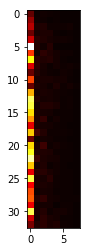

In [0]:
plt.imshow(saliency[0][0:33, (33 + 8*22)+7:], cmap=plt.cm.hot)

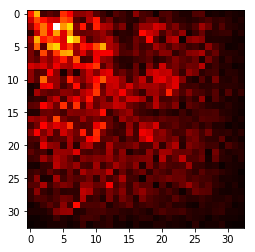

In [0]:
plt.imshow(saliency[0][0:33, 0:33], cmap=plt.cm.hot)

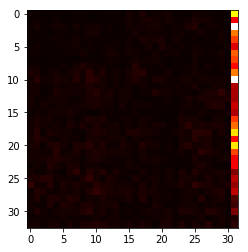

In [0]:
plt.imshow(saliency[0][0:33, 33:(33+8*4)], cmap=plt.cm.hot)

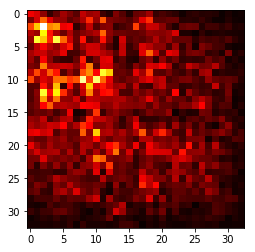

In [0]:
plt.imshow(saliency[0][0:33, (33 + 8*4-1):(33 + 8*8)], cmap=plt.cm.hot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


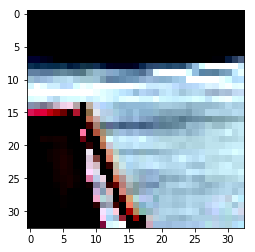

In [0]:
plt.imshow(convert2channel_last(images[0])[0:33, (33 + 8*4-1):(33 + 8*8)])

### 1.2 Receptive field by pre-trained model

In [0]:
criterion = torch.nn.functional.cross_entropy
saliency = compute_saliency_map(images, labels, bagnet33_rf_pre, criterion, device)
print('corresponding receptive fields of units at {}'.format(coordinate))
plot_saliency(images, saliency, alpha=0.3)

Output hidden; open in https://colab.research.google.com to view.

## 2. Confirm that one unit in the output before the last fully connected layer is a 2048-dimension vector.

In [0]:
bagnet33_db = bagnet33_debug(pretrained=True).to(device)

In [0]:
bs = 20
original, label = samples(dataset='imagenet', index=1, batchsize=bs, shape=(224, 224), data_format='channels_first')

# preprocess sample image
images = imagenet_preprocess(original)
images = original
images = torch.from_numpy(images).to(device)

patchsize = 33
patches = images.permute(0, 2, 3, 1)
print(patches.shape)
patches = patches.unfold(1, patchsize, 8).unfold(2, patchsize, 8)
print(patches.shape)
patches = patches.contiguous().view((bs, -1, 3, patchsize, patchsize))
print(patches.shape)

torch.Size([20, 224, 224, 3])
torch.Size([20, 24, 24, 3, 33, 33])
torch.Size([20, 576, 3, 33, 33])


In [0]:
with torch.no_grad():
    logits = bagnet33_db(patches[0])

BagNet: shape after conv1 torch.Size([576, 64, 33, 33])

BagNet: shape after conv2 torch.Size([576, 64, 31, 31])

Bottleneck: shape before downsampling torch.Size([576, 64, 31, 31])
Bottleneck: shape after downsampling torch.Size([576, 256, 16, 16])
Bottleneck: shape of out torch.Size([576, 256, 15, 15])
BagNet: shape after layer1 torch.Size([576, 256, 15, 15])

Bottleneck: shape before downsampling torch.Size([576, 256, 15, 15])
Bottleneck: shape after downsampling torch.Size([576, 512, 8, 8])
Bottleneck: shape of out torch.Size([576, 512, 7, 7])
BagNet: shape after layer2 torch.Size([576, 512, 7, 7])

Bottleneck: shape before downsampling torch.Size([576, 512, 7, 7])
Bottleneck: shape after downsampling torch.Size([576, 1024, 4, 4])
Bottleneck: shape of out torch.Size([576, 1024, 3, 3])
BagNet: shape after layer3 torch.Size([576, 1024, 3, 3])

Bottleneck: shape before downsampling torch.Size([576, 1024, 3, 3])
Bottleneck: shape after downsampling torch.Size([576, 2048, 3, 3])
Bottlen

## 3. Generate 24x24 33x33 patches and make prediction

In [0]:
# load pretrained model
pytorch_model = bagnets.pytorch.bagnet33(pretrained=True).to(device)

In [0]:
bs = 20
original, label = samples(dataset='imagenet', index=1, batchsize=bs, shape=(224, 224), data_format='channels_first')

# preprocess sample image
#images = imagenet_preprocess(original)
images = original
images = torch.from_numpy(images).to(device)

patchsize = 33
patches = images.permute(0, 2, 3, 1)
print(patches.shape)
patches = patches.unfold(1, patchsize, 8).unfold(2, patchsize, 8)
print(patches.shape)
#patches = patches.contiguous().view((bs, -1, 3, patchsize, patchsize))
#print(patches.shape)

torch.Size([20, 224, 224, 3])
torch.Size([20, 24, 24, 3, 33, 33])


### 3.1 Inspect these patches of the first image

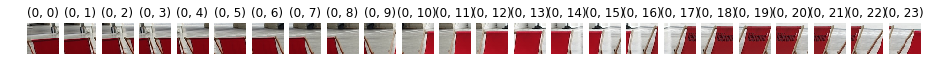

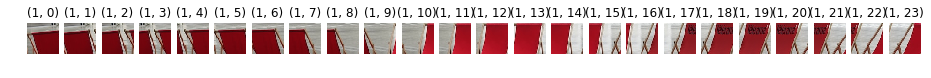

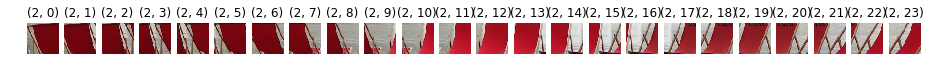

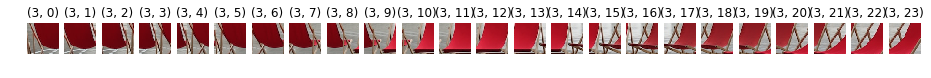

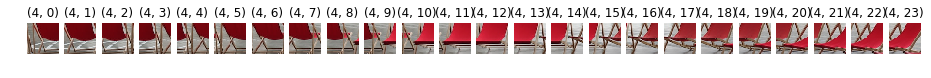

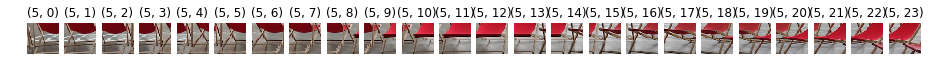

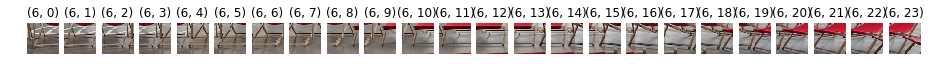

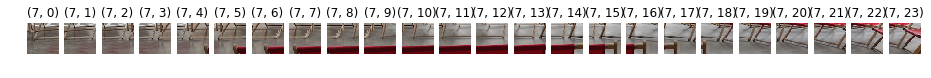

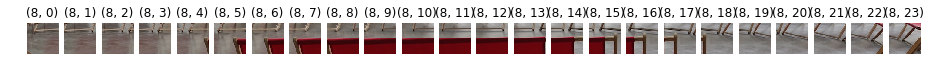

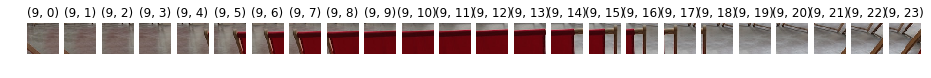

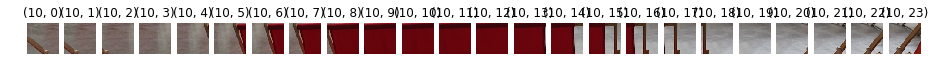

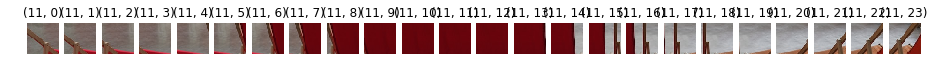

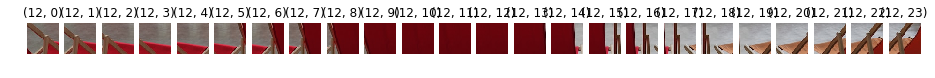

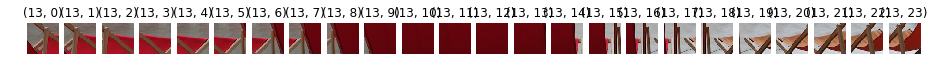

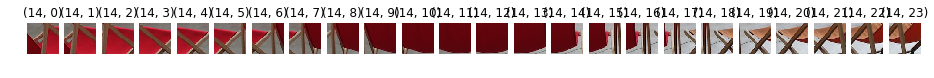

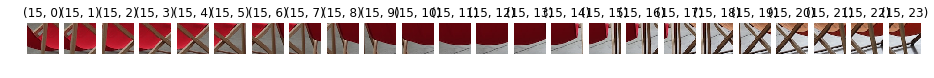

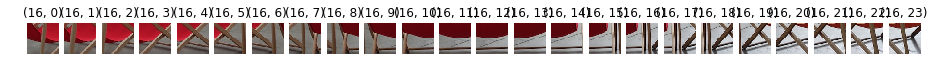

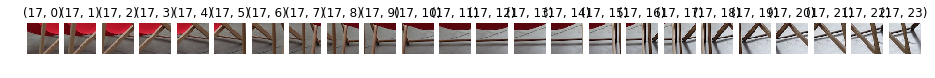

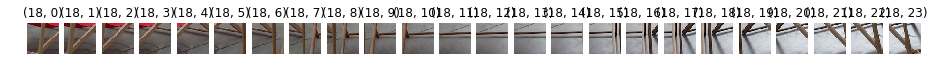

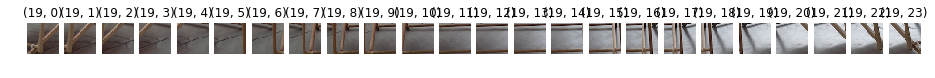

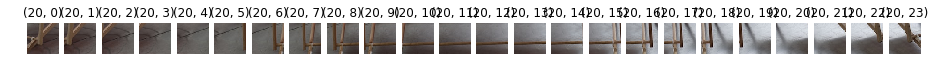

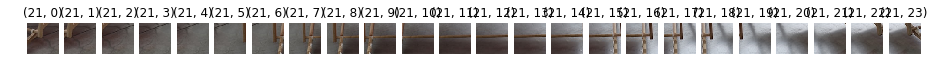

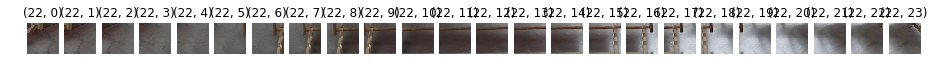

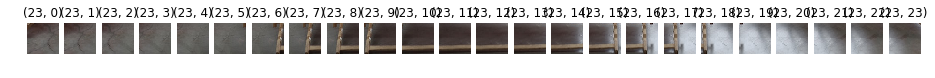

In [0]:
for i in range(24):
    fig = plt.figure(figsize=(16, 8))
    for j in range(24):
        ax = plt.subplot(1, 24, j+1)
        ax.set_title('({}, {})'.format(i, j))
        plt.imshow(convert2channel_last((patches[0][i][j]/255.).cpu().numpy()))
        plt.axis('off')
    plt.show()

In [0]:
def bagnet_patch_predict(bagnet, patches, device, batch_size=256, return_class=True):
    """ Take a batch of patches as input, and make prediction using bagnet.
    """
    N, M, C, P, P = patches.shape
    with torch.no_grad():
        cum_logits = torch.zeros(N, 1000).to(device) # ImageNet has 1000 classes
        for n in range(N):
            for batch_patches in torch.split(patches[n], batch_size):
                logits = bagnet(batch_patches)
                sum_logits = torch.sum(logits, dim=0)
                cum_logits[n, :] += sum_logits
        p = F.softmax(cum_logits/M, dim=1)
        if return_class:
            return torch.argmax(p, dim=1)
        else:
            return p.cpu().numpy()

### 3.2 Make predictions using patches

In [0]:
pytorch_model = bagnets.pytorch.bagnet33(pretrained=True).to(device)

In [0]:
bs = 20
original, label = samples(dataset='imagenet', index=1, batchsize=bs, shape=(224, 224), data_format='channels_first')

# preprocess sample image
images = imagenet_preprocess(original)
images = torch.from_numpy(images).to(device)

patchsize = 33
patches = images.permute(0, 2, 3, 1)
print(patches.shape)
patches = patches.unfold(1, patchsize, 8).unfold(2, patchsize, 8)
print(patches.shape)
patches = patches.contiguous().view((bs, -1, 3, patchsize, patchsize)).to(device)
print(patches.shape)

torch.Size([20, 224, 224, 3])
torch.Size([20, 24, 24, 3, 33, 33])
torch.Size([20, 576, 3, 33, 33])


In [0]:
with torch.no_grad():
    prediction = bagnet_patch_predict(pytorch_model, patches, device, return_class=True)

In [0]:
prediction

tensor([463, 463, 600, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 852,
        463, 463, 463, 463, 600, 463], device='cuda:0')

In [0]:
label

array([559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
       129,  99, 251,  22, 317, 305, 243])

**Comment:** Patch prediction still doesn't quite work.

### 3.3 Reference: image prediction

In [0]:
with torch.no_grad():
    logits = pytorch_model(images)

In [0]:
p = F.softmax(logits, dim=1)
torch.argmax(p, dim=1)

tensor([559, 438, 990, 949, 853, 609, 751, 915, 455, 541, 636, 741, 471, 129,
         99, 251,  22, 317, 302, 243], device='cuda:0')

### 4. Saliency map of a patch

In [0]:
bs = 20
original, label = samples(dataset='imagenet', index=1, batchsize=bs, shape=(224, 224), data_format='channels_first')

# preprocess sample image
images = imagenet_preprocess(original)
images = torch.from_numpy(images)

patchsize = 33
patches = images.permute(0, 2, 3, 1)
print(patches.shape)
patches = patches.unfold(1, patchsize, 8).unfold(2, patchsize, 8)
print(patches.shape)
patches = patches.contiguous().view((bs, -1, 3, patchsize, patchsize))
print(patches.shape)

torch.Size([20, 224, 224, 3])
torch.Size([20, 24, 24, 3, 33, 33])
torch.Size([20, 576, 3, 33, 33])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BagNet: shape after layer4 torch.Size([5, 2048, 1, 1])



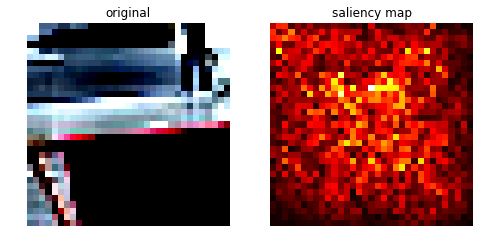

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


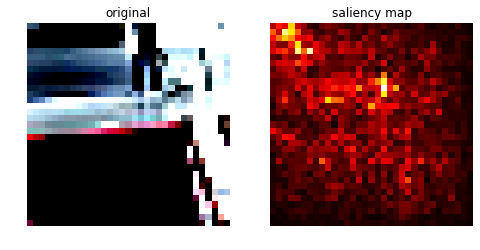

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


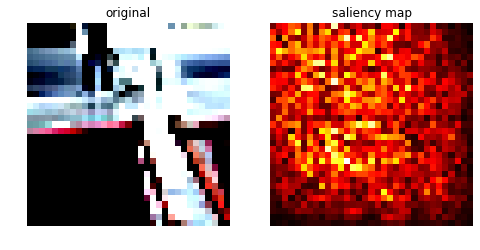

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


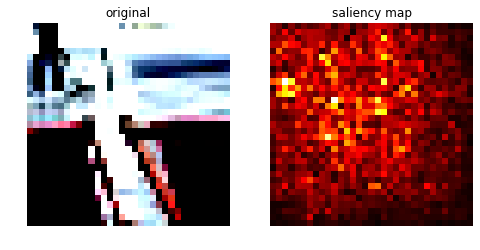

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


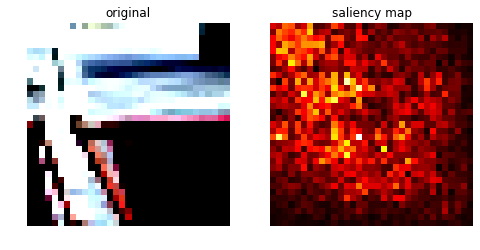

In [0]:
criterion = torch.nn.functional.cross_entropy
bagnet33_rf_rand.mask = None
saliency = compute_saliency_map(patches[0, 0:5, :, :, :].numpy(), label[0:5], bagnet33_rf_rand, criterion, device)
plot_saliency(patches[0, 0:5, :, :, :].numpy(), saliency)

**Comment:** The saliency maps of the first patch (at the top-left corner) generated by feeding in the entire image and directly feeding in the path, are different. This may indicate that the two ways of using Bagnet are not equivalent.